<a href="https://colab.research.google.com/github/Kunal-s-git/Kunal-s-git/blob/main/Brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook is for building an image classifier for predicting the tumor present in human brain.**

**1** Importing the libraries and loading the data.

In [7]:
import os
import cv2
import imghdr
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

Dataset link : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection


In [45]:
data_dir='data'
os.listdir(data_dir)
os.listdir(os.path.join(data_dir,'yes'))

['.ipynb_checkpoints', 'yes', 'no']

In [9]:
data=keras.utils.image_dataset_from_directory(data_dir)

Found 253 files belonging to 2 classes.


In [10]:
data_iterator=data.as_numpy_iterator()
batch=data_iterator.next()

In [11]:
#images represented as numpy array
batch[0].shape

(32, 256, 256, 3)

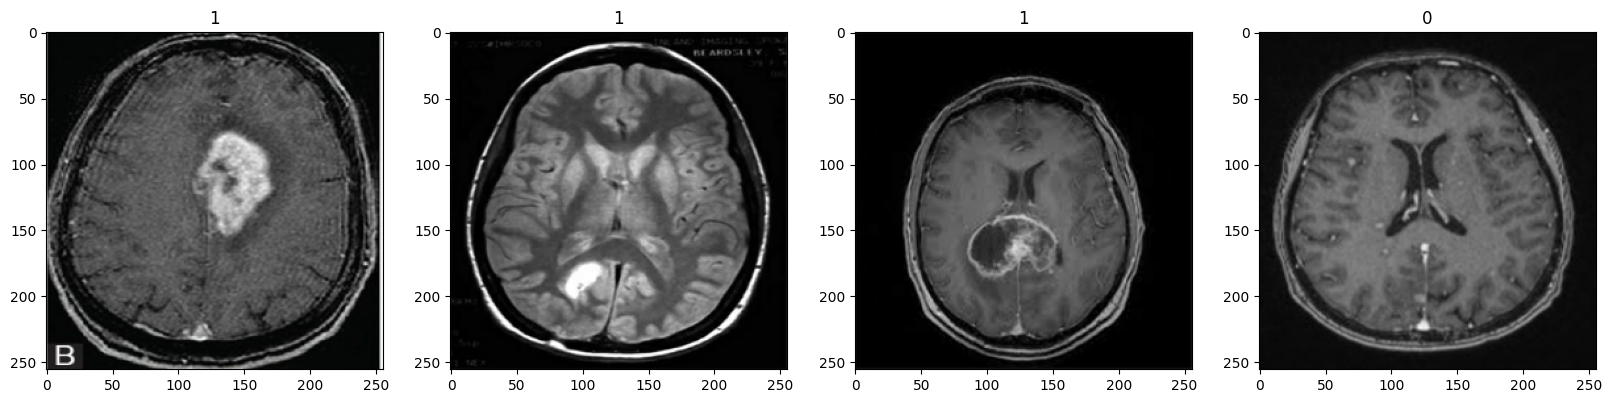

In [12]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

With this figure we can define :
*   Class 1 as having brain tumor.
*   Class 0 as not having.

In [13]:
print(batch[0].min())
print(batch[0].max())

0.0
255.0


Scaling the images.

In [14]:
data=data.map(lambda x,y:(x/255,y))

In [15]:
scaled_iterator=data.as_numpy_iterator()
batch=scaled_iterator.next()

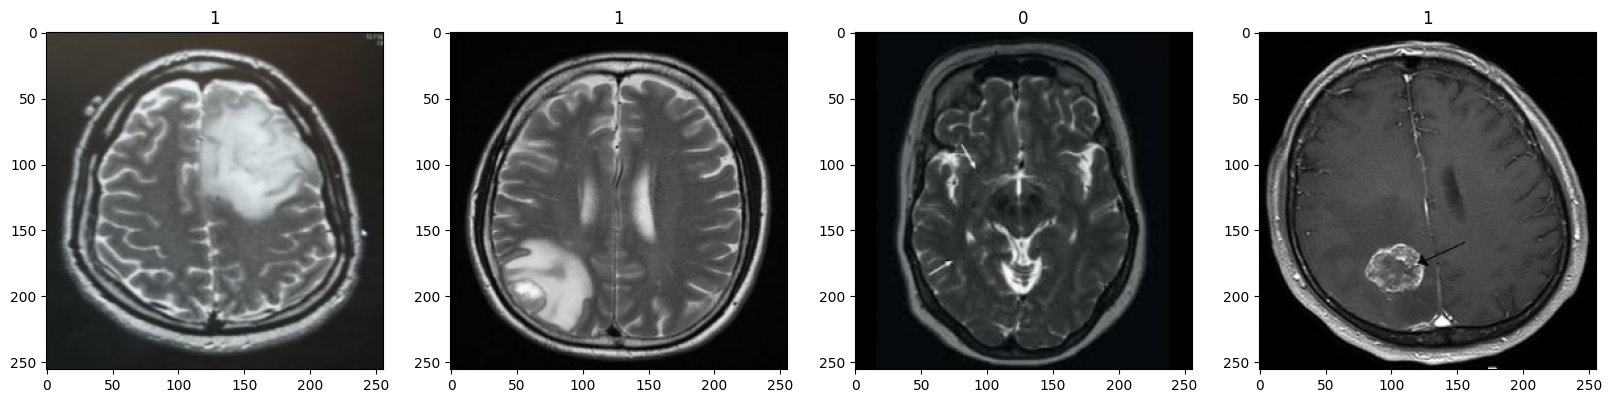

In [16]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

**2>** Splitting the data.

In [17]:
len(data)

8

In [18]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.3)
test_size=int(len(data)*0.2)

In [19]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

print(f'train data size = {len(train)}\nvalidation data size = {len(val)}\ntest data size = {len(test)}')

train data size = 5
validation data size = 2
test data size = 1


**3->** Defining the model using the TensorFlow.

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [21]:
model=keras.Sequential([
    layers.Conv2D(filters=16,kernel_size=3,strides=1,activation='relu',padding='SAME',input_shape=(256,256,3)),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(filters=32,kernel_size=3,strides=1,activation='relu',padding='same'),
    layers.MaxPool2D(),

    layers.Conv2D(filters=64,kernel_size=3,strides=1,activation='relu',padding="SAME"),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(256,'relu'),
    layers.Dense(128,'relu'),
    layers.Dense(1,'sigmoid'),
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)        0

In [23]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])

In [24]:
logdir='logs'

In [25]:
tf_callbacks=keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
history=model.fit(train,epochs=30,validation_data=val,callbacks=[tf_callbacks],verbose=0)

In [27]:
history_df=pd.DataFrame(history.history)
print(history_df.head())

       loss  binary_accuracy  val_loss  val_binary_accuracy
0  1.112609          0.52500  0.649930             0.750000
1  0.589069          0.77500  0.512997             0.812500
2  0.539659          0.77500  0.466718             0.781250
3  0.478060          0.80000  0.457403             0.812500
4  0.453538          0.83125  0.363861             0.890625


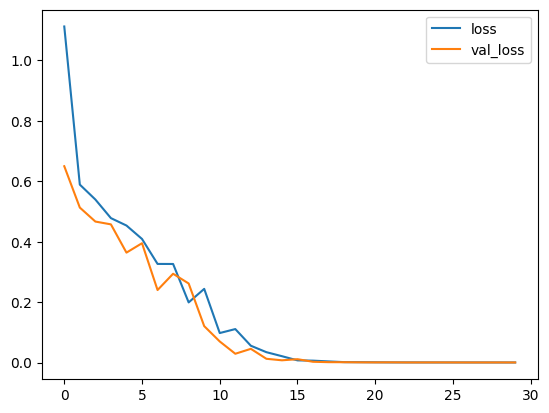

In [28]:
history_df.loc[:,['loss','val_loss']].plot()
# history_df.loc[:,['binary_accuracy','val_binary_accuracy']].plot()
plt.show()

In [29]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [30]:
prec=Precision()
rec=Recall()
b_acc=BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator():
  X,y=batch
  y_pred=model.predict(X)
  prec.update_state(y,y_pred)
  rec.update_state(y,y_pred)
  b_acc.update_state(y,y_pred)

1/1 [==============================] - 1s 685ms/step


In [40]:
print(f'Precision of the model is {(prec.result())*100}%')
print(f'Recall of the model is {rec.result()*100}%')
print(f'Accuracy of the model is {b_acc.result()*100}%')

Precision of the model is 100.0%
Recall of the model is 100.0%
Accuracy of the model is 100.0%


Model performed really great with all the metrics with 100% results.

**** Saving the model.

In [41]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models','Brain_tumor_classifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Making predictions for the new data or images.
Just upload the file.

In [52]:
print()
inp=input('Do you want to predict the new data:\tYes or No. ')
if inp=='Yes' or inp=='yes':
  n_pred=cv2.imread() #file name in brackets
  plt.imshow(cv2.cvtColor(n_pred,cv2.COLOR_BGR2RGB))
  plt.show()
  n_pred=tf.image.resize(n_pred,(256,256))

  y_fore=model.predict(np.expand_dims(n_pred/256,0))
  print(y_fore)
  if y_fore > 0.5:
    print('Person might have the brain tumor according to the model.')
  else:
    print('Person don\'t posses any characteristics of having the brain tumor.')


Do you want to predict the new data:	Yes or No. no
